**Next method**

In [1]:
import sys
print(sys.executable)

c:\Users\edward_b\OneDrive - Institute for Fiscal Studies\Work\Brazil social insurance\venv\Scripts\python.exe


***Pyautogui***

In [85]:
import pyautogui
import os
import time
import subprocess
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from bs4 import BeautifulSoup
import psutil
from selenium.webdriver.support.ui import Select
import matplotlib.pyplot as plt
import logging
from logging.handlers import RotatingFileHandler
import random

In [3]:
os.chdir("C:/Users/edward_b/OneDrive - Institute for Fiscal Studies/Work/Brazil social insurance")

In [28]:
# Data storage
data = []

# Function to kill Chrome processes
def kill_chrome():
    """Kill all Chrome processes."""
    for proc in psutil.process_iter(['pid', 'name']):
        if 'chrome' in proc.info['name'].lower():
            try:
                proc.kill()
            except psutil.NoSuchProcess:
                pass

# Scraper function
def scrape_data(cnpj,year, soup, table):
    if not table:
        '''
        print(f"No table found for {cnpj}")
        data.append({'cnpj': cnpj,
                      'periodo': year,
                      'data_found': False})
        return
        '''
    rows = table.find('tbody').find_all('tr', class_='pa')
    for row in rows:
        cells = row.find_all('td')
        if len(cells) < 10:
            continue
        data.append({
            'cnpj': cnpj,
            'periodo': cells[1].get_text(strip=True),
            'apurado': cells[2].get_text(strip=True),
            'INSS': cells[3].get_text(strip=True),
            'principal': cells[4].get_text(strip=True),
            'multa': cells[5].get_text(strip=True),
            'juros': cells[6].get_text(strip=True),
            'total': cells[7].get_text(strip=True),
            'vencimento': cells[8].get_text(strip=True),
            'acolhimento': cells[9].get_text(strip=True),
            'data_found': True
        })

**Import master**

In [8]:
path = "raw/CNPJ numbers"
cnpj_master = pd.read_csv(f'{path}/simples.csv', sep=',', encoding='utf-8')
cnpj_master = cnpj_master[['cnpj_basico','opcao_mei']]

C:\Users\edward_b\AppData\Local\Temp\ipykernel_37168\2426474582.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  cnpj_master = pd.read_csv(f'{path}/simples.csv', sep=',', encoding='utf-8')


In [9]:
# find length of cnpj
cnpj_master["length cnpj_basico"] = cnpj_master["cnpj_basico"].astype(str).str.len()


In [10]:
pd.crosstab(cnpj_master["length cnpj_basico"], cnpj_master["opcao_mei"], margins=True, margins_name="Total")

opcao_mei,0,1,Total
length cnpj_basico,,,
1,3,0,3
2,11,0,11
3,112,0,112
4,1354,24,1378
5,9966,220,10186
6,151689,3631,155320
7,2864598,53032,2917630
8,23322728,15313596,38636324
Total,26350461,15370503,41720964


In [11]:
cnpj_master["cnpj_basico"] = cnpj_master["cnpj_basico"].astype(str)

In [12]:
cnpj_master = cnpj_master[cnpj_master['opcao_mei'] == 1]
cnpj_master.drop(columns=['length cnpj_basico'], inplace=True)

**Import example full file**

In [13]:
cnpj_test = pd.read_csv(f'{path}/establishmentsAC.csv', sep=',', encoding='utf-8')
cnpj_test = cnpj_test[['cnpj']]
cnpj_test["cnpj_basico"] = cnpj_test["cnpj"].astype(str).str[:8]

In [14]:
cnpj_merged = pd.merge(cnpj_master, cnpj_test, left_on='cnpj_basico', right_on='cnpj_basico', how='inner')

<Axes: >

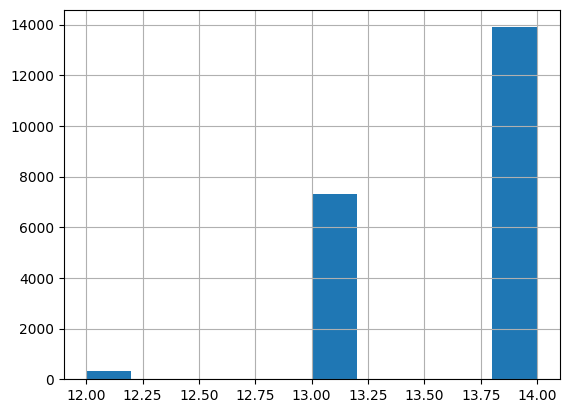

In [15]:
cnpj_merged["cnpj"] = cnpj_merged["cnpj"].astype(str)
cnpj_merged["cnpj"].str.len().hist()

In [16]:
cnpj_merged = cnpj_merged[cnpj_merged['cnpj'].str.len() == 14]
cnpj_merged = cnpj_merged.drop_duplicates(subset=['cnpj'], keep='first')

In [17]:
cnpj_merged.to_csv('MEI_numbers.csv', sep=',', encoding='utf-8', index=False)

**Load in MEI numbers and start scraping**

In [86]:
cnpj_merged = pd.read_csv('MEI_numbers.csv', sep=',', encoding='utf-8')

In [87]:
proxy_list = pd.read_csv("scripts/proxies.txt", sep=',', encoding='utf-8', header=None, names=['proxy'])
proxy_list = proxy_list["proxy"].to_list()

In [88]:
cnpj_merged

,cnpj_basico,opcao_mei,cnpj
0,30065905,1,30065905000100
1,32831731,1,32831731000175
2,22218125,1,22218125000125
3,15028093,1,15028093000130
4,28915161,1,28915161000124
...,...,...,...
13889,35250850,1,35250850000122
13890,12352071,1,12352071000132
13891,25054527,1,25054527000120
13892,29879083,1,29879083000112


In [89]:
# get random sample of 10
cnpj_merged = cnpj_merged.sample(n=3, random_state=10)
#convert cnpj's to a list
cnpj_list = cnpj_merged['cnpj'].tolist()

In [90]:
cnpj_merged.shape # 13,894 obs

(3, 3)

**Set up scraper**

In [91]:
cnpj_list = [str(i) for i in cnpj_list]
cnpj_list

['28740844000198', '11757216000112', '33962463000193']

In [55]:
cnpj_list = ["12902387000150"]
cnpj_list

['12902387000150']

In [92]:
import shutil
import os

chrome_profile_path = "C:/Temp/ChromeDebug"
if os.path.exists(chrome_profile_path):
    shutil.rmtree(chrome_profile_path)  # delete the profile folder

In [93]:
log_file = 'mei_scraper_log.log'
with open(log_file, 'w'):
    pass  # This empties the file
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        RotatingFileHandler(log_file, maxBytes=5*1024*1024, backupCount=3),  # 5MB per file
        logging.StreamHandler()  # Optional: print to console too
    ]
)

In [94]:
# ---- Define url and cnpj list ----
url = "https://www8.receita.fazenda.gov.br/SimplesNacional/Aplicacoes/ATSPO/pgmei.app/Identificacao"
data = []
timings = []
total_start_time = time.time()



for cnpj in cnpj_list:
    proxy = random.choice(proxy_list)
    logging.info("Processing CNPJ:", cnpj)
    start_time = time.time()

    try:

        # ---- Step 1: Start Chrome in remote debug mode ----
        subprocess.Popen([
            r"C:/Program Files/Google/Chrome/Application/chrome.exe",
            f"--proxy-server={proxy}",
            "--remote-debugging-port=9222",
            "--user-data-dir=" + chrome_profile_path,
            "--start-maximized",  # or "--start-fullscreen"
            "--disable-popup-blocking",  # optional, disable for debugging only
            "--disable-extensions",
            "--no-first-run",
            "--no-default-browser-check"
        ])
        time.sleep(2)  # Give Chrome time to launch

        # ---- Step 2: Use pyautogui to interact with the site ----
        pyautogui.hotkey('ctrl', 'l')
        pyautogui.typewrite(url, interval=0.01)
        pyautogui.press('enter')  
        time.sleep(2)

        pyautogui.moveTo(x=1037, y=387, duration=1)
        pyautogui.click()
        pyautogui.typewrite(cnpj, interval=0.1)

        pyautogui.moveTo(x=1043, y=514, duration=1)
        pyautogui.click()
        time.sleep(2)

        options = Options()
        options.add_experimental_option("debuggerAddress", "127.0.0.1:9222")
        options.add_argument(f'--proxy-server={proxy}')
        driver = webdriver.Chrome(options=options)
        wait = WebDriverWait(driver, 3)

        driver.get("https://www8.receita.fazenda.gov.br/SimplesNacional/Aplicacoes/ATSPO/pgmei.app/emissao")
        time.sleep(1.5)

        # First try: Bootstrap-styled dropdown
        try:
            dropdown_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-id="anoCalendarioSelect"]')))
            dropdown_button.click()
            time.sleep(1)

            year_elements = wait.until(EC.presence_of_all_elements_located(
                (By.CSS_SELECTOR, ".dropdown-menu.inner li a span.text")
            ))
            enabled_years = [el.text.strip() for el in year_elements if el.text.strip()]
            # remove elements from the list that contain "Não optante"
            enabled_years = [year for year in enabled_years if "Não optante" not in year]

            # Raise an exception if no enabled years are found
            if not enabled_years:
                raise ValueError("No enabled years found in the dropdown menu.")

            print("Bootstrap dropdown enabled years for CNPJ ", cnpj , ":", enabled_years)
            use_bootstrap = True
            

        except Exception as e:
            print("Bootstrap dropdown failed, falling back to native <select> method.")
            # Try native <select>
            select_element = wait.until(EC.presence_of_element_located((By.ID, "anoCalendarioSelect")))
            dropdown = Select(select_element)
            enabled_years = [o.text.strip() for o in dropdown.options if o.text.strip()]
            enabled_years = [year for year in enabled_years if "Não optante" not in year]
            print("Native <select> enabled years for CNPJ ", cnpj,":", enabled_years)
            use_bootstrap = False

        print("scraping years", enabled_years)
        enabled_years = [str(max(enabled_years))]
        enabled_years.insert(0, "2010")  #add a year to the start of the list
        
        for index, year in enumerate(enabled_years):
            try:
                if use_bootstrap:
                    dropdown_button = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'button[data-id="anoCalendarioSelect"]')))
                    driver.execute_script("arguments[0].click();", dropdown_button)
                    time.sleep(1.5)  # allow dropdown to render
                    
                    print("Clicking on year:", year)
                    year_option = wait.until(EC.element_to_be_clickable(
                        (By.XPATH, f"//span[@class='text' and normalize-space(text())='{year}']")
                    ))
                    time.sleep(2)
                    driver.execute_script("arguments[0].click();", year_option)
                    #ActionChains(driver).move_to_element(year_option).click().perform()
                    print(f"Selected (Bootstrap) year: {year}")
                else:
                    dropdown = Select(driver.find_element(By.ID, "anoCalendarioSelect"))
                    dropdown.select_by_visible_text(year)
                    print(f"Selected (native) year: {year}")

                ok_button = driver.find_element(By.CSS_SELECTOR, "button[type='submit']")
                ok_button.click()
                time.sleep(2)
                
                # check if table is present
                soup = BeautifulSoup(driver.page_source, 'html.parser')
                table = soup.find('table', class_='table table-hover table-condensed emissao is-detailed')
                if not table:
                    print(f"No table found for {cnpj} in year {year}. Skipping the rest.")
                    # Mark all remaining years as not found
                    for remaining_year in enabled_years[index:]:
                        data.append({
                            'cnpj': cnpj,
                            'periodo': remaining_year,
                            'data_found': False
                        })
                    break  # Exit the year loop
                    
                scrape_data(cnpj,year, soup, table)

                driver.back()
                time.sleep(2)

            except Exception as e:
                print(f"Error with year {year}:", e)

    except Exception as outer_error:
        print(f"Fatal error with CNPJ {cnpj}:", outer_error)

    finally:
        try:
            driver.quit()
        except:
            pass
        kill_chrome()
        end_time = time.time()  # ⏱ End timer
        elapsed = end_time - start_time
        timings.append(elapsed)
        total_elapsed = time.time() - total_start_time
        average_elapsed = sum(timings) / len(timings)
        
        logging.info(f"Finished CNPJ: {cnpj} in {elapsed:.2f} seconds\n")
        logging.info(f"Average time per CNPJ: {average_elapsed:.2f} seconds")
        logging.info(f"Total time elapsed: {total_elapsed:.2f} seconds\n")
        time.sleep(2)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\logging\handlers.py", line 73, in emit
    if self.shouldRollover(record):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\logging\handlers.py", line 197, in shouldRollover
    msg = "%s\n" % self.format(record)
                   ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\Python

Fatal error with CNPJ 28740844000198: Message: unknown error: net::ERR_TUNNEL_CONNECTION_FAILED
  (Session info: chrome=136.0.7103.114)
Stacktrace:
	GetHandleVerifier [0x00007FF6FB29CF45+75717]
	GetHandleVerifier [0x00007FF6FB29CFA0+75808]
	(No symbol) [0x00007FF6FB068F9A]
	(No symbol) [0x00007FF6FB0659F4]
	(No symbol) [0x00007FF6FB056789]
	(No symbol) [0x00007FF6FB0584F8]
	(No symbol) [0x00007FF6FB056A96]
	(No symbol) [0x00007FF6FB056516]
	(No symbol) [0x00007FF6FB0561DA]
	(No symbol) [0x00007FF6FB053E8A]
	(No symbol) [0x00007FF6FB05465C]
	(No symbol) [0x00007FF6FB06CF3A]
	(No symbol) [0x00007FF6FB11013E]
	(No symbol) [0x00007FF6FB0E737A]
	(No symbol) [0x00007FF6FB10F39C]
	(No symbol) [0x00007FF6FB0E7153]
	(No symbol) [0x00007FF6FB0B0421]
	(No symbol) [0x00007FF6FB0B11B3]
	GetHandleVerifier [0x00007FF6FB59D71D+3223453]
	GetHandleVerifier [0x00007FF6FB597CC2+3200322]
	GetHandleVerifier [0x00007FF6FB5B5AF3+3322739]
	GetHandleVerifier [0x00007FF6FB2B6A1A+180890]
	GetHandleVerifier [0x000

2025-05-23 12:36:44,626 - INFO - Finished CNPJ: 28740844000198 in 14.55 seconds

2025-05-23 12:36:44,629 - INFO - Average time per CNPJ: 14.55 seconds
2025-05-23 12:36:44,630 - INFO - Total time elapsed: 14.56 seconds



KeyboardInterrupt: 

In [ ]:
data

In [70]:
df = pd.DataFrame(data)
df

,cnpj,periodo,data_found,apurado,INSS,principal,multa,juros,total,vencimento,acolhimento
0,28740844000198,2025,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12902387000150,Janeiro/2025,True,Sim,,Liquidado,-,-,-,-,-
2,12902387000150,Fevereiro/2025,True,Sim,,Liquidado,-,-,-,-,-
3,12902387000150,Março/2025,True,Sim,,Liquidado,-,-,-,-,-
4,12902387000150,Abril/2025,True,Sim,,Liquidado,-,-,-,-,-
5,12902387000150,Maio/2025,True,Sim,,Liquidado,-,-,-,-,-
6,12902387000150,Junho/2025,True,Sim,,Liquidado,-,-,-,-,-
7,12902387000150,Julho/2025,True,Sim,,A Vencer,"R$ 81,90","R$ 0,00","R$ 0,00","R$ 81,90",20/08/2025
8,12902387000150,Agosto/2025,True,Sim,,A Vencer,"R$ 81,90","R$ 0,00","R$ 0,00","R$ 81,90",22/09/2025
9,12902387000150,Setembro/2025,True,Sim,,A Vencer,"R$ 81,90","R$ 0,00","R$ 0,00","R$ 81,90",20/10/2025


In [19]:
pd.DataFrame(data).to_csv('MEI_data.csv', sep=',', encoding='utf-8', index=False)